# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Инструкция по выполнению проекта

Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Эти редкие случаи легко пропустить, если всегда применять только бустинг.

Поэкспериментируйте и сравните характеристики моделей: время обучения, время предсказания, точность результата.

**Основные шаги:**
1. Загрузите данные, путь к файлу: /datasets/autos.csv.
2. Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
3. Подготовьте выборки для обучения моделей.
4. Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
5. Проанализируйте время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

**Примечания:**
- Для оценки качества моделей применяйте метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del.

### Описание данных

Данные находятся в файле /datasets/autos.csv

**Признаки**
- *DateCrawled* — дата скачивания анкеты из базы
- *VehicleType* — тип автомобильного кузова
- *RegistrationYear* — год регистрации автомобиля
- *Gearbox* — тип коробки передач
- *Power* — мощность (л. с.)
- *Model* — модель автомобиля
- *Kilometer* — пробег (км)
- *RegistrationMonth* — месяц регистрации автомобиля
- *FuelType* — тип топлива
- *Brand* — марка автомобиля
- *NotRepaired* — была машина в ремонте или нет
- *DateCreated* — дата создания анкеты
- *NumberOfPictures* — количество фотографий автомобиля
- *PostalCode* — почтовый индекс владельца анкеты (пользователя)
- *LastSeen* — дата последней активности пользователя

**Целевой признак**
- *Price* — цена (евро)

## Подготовка данных

Импорт необходимых для исследования инструментов

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor, cv, train
import lightgbm
from sklearn.metrics import mean_squared_error
import time

### Открытие файла и знакомство с данными

In [ ]:
df = pd.read_csv('/datasets/autos.csv')
display(df.head())
df.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Уникальные объекты в NumberOfPictures

In [ ]:
df['NumberOfPictures'].unique()

array([0])

Удаление признаков, которые в исследовании не помогут

In [ ]:
df = (
    df.drop(
        columns=['DateCrawled', 'Model', 
                 'RegistrationMonth', 'DateCreated', 
                 'LastSeen', 'NumberOfPictures'], axis=1)
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Kilometer         354369 non-null  int64 
 6   FuelType          321474 non-null  object
 7   Brand             354369 non-null  object
 8   NotRepaired       283215 non-null  object
 9   PostalCode        354369 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 27.0+ MB


Проверка уникальных объектов в целевом признаке

In [ ]:
display(df['Price'].isna().sum())
df['Price'].value_counts()

0

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64

Удаление нулевых значений в целевом признаке

In [ ]:
df = df.loc[df['Price'] != 0]

Удаление автомобилей со стоимостью менее 50 евро

In [ ]:
df = df.loc[df['Price'] >=50 ]

Проверка уникальных объектов в других признаках

In [ ]:
display(df['VehicleType'].value_counts())
display(df['Gearbox'].value_counts())
df['FuelType'].value_counts()

sedan          89169
small          77792
wagon          63524
bus            28272
convertible    19820
coupe          15568
suv            11766
other           3056
Name: VehicleType, dtype: int64

manual    260592
auto       64690
Name: Gearbox, dtype: int64

petrol      210086
gasoline     96973
lpg           5155
cng            550
hybrid         226
other          156
electric        87
Name: FuelType, dtype: int64

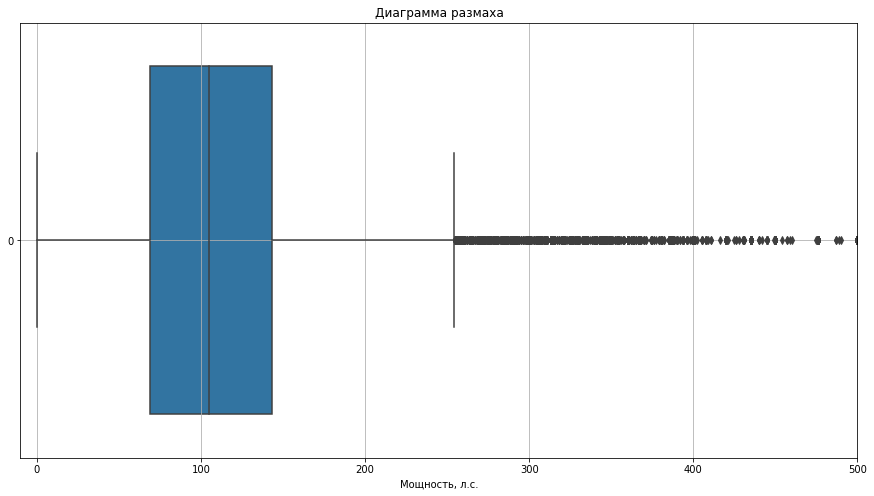

In [ ]:
plt.figure(figsize=(15, 8))

sns.boxplot(data=df['Power'], orient='h')

plt.xlim(-10, 500)

plt.title('Диаграмма размаха')
plt.xlabel('Мощность, л.с.')
plt.grid(True)

plt.show()

Удаление автомобилей с мощностью двигателя более 250 л.с.

In [ ]:
df = df.loc[df['Power'] < 250]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333981 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             333981 non-null  int64 
 1   VehicleType       301424 non-null  object
 2   RegistrationYear  333981 non-null  int64 
 3   Gearbox           317428 non-null  object
 4   Power             333981 non-null  int64 
 5   Kilometer         333981 non-null  int64 
 6   FuelType          305723 non-null  object
 7   Brand             333981 non-null  object
 8   NotRepaired       270129 non-null  object
 9   PostalCode        333981 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 28.0+ MB


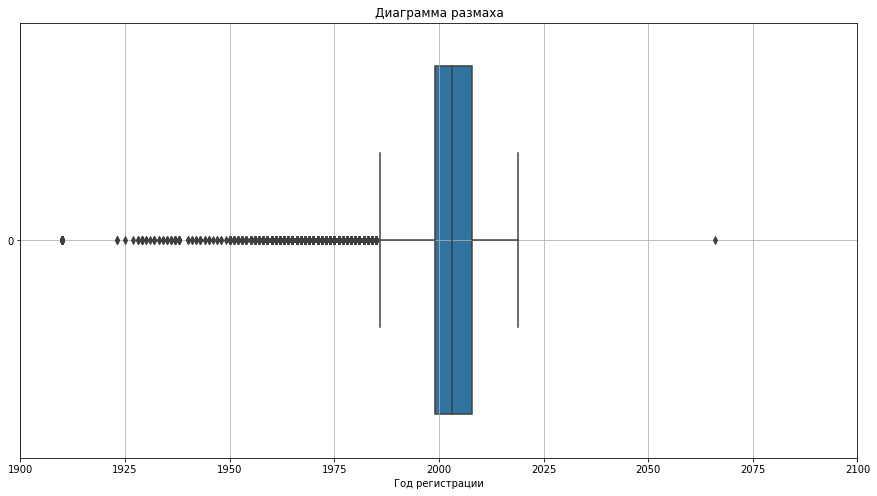

In [ ]:
plt.figure(figsize=(15, 8))

sns.boxplot(data=df['RegistrationYear'], orient='h')

plt.xlim(1900, 2100)

plt.title('Диаграмма размаха')
plt.xlabel('Год регистрации')
plt.grid(True)

plt.show()

Удаление автомобилей с годом производства менее 1986 и более 2020

In [ ]:
df = df.loc[df['RegistrationYear'] < 2020]
df = df.loc[df['RegistrationYear'] > 1986]

Проверка наличия пропусков в количественных признаках

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328038 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             328038 non-null  int64 
 1   VehicleType       296250 non-null  object
 2   RegistrationYear  328038 non-null  int64 
 3   Gearbox           312482 non-null  object
 4   Power             328038 non-null  int64 
 5   Kilometer         328038 non-null  int64 
 6   FuelType          300850 non-null  object
 7   Brand             328038 non-null  object
 8   NotRepaired       266037 non-null  object
 9   PostalCode        328038 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 27.5+ MB


В количественных признаках пропусков не осталось.
Заполнение пропущенных значений категориальных признаков заглушкой *unknown*

In [ ]:
df = df.fillna('unknown')

Обозначение категориальных признаков

In [ ]:
cat_features = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'NotRepaired']

Преобразуем категориальные признаки в численные с помощью техники порядкового кодирования OE

In [ ]:
encoder = OrdinalEncoder(dtype=np.int16)
encoder.fit(df[cat_features])
df[cat_features] = encoder.transform(df[cat_features])
df = df.astype(np.int16)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328038 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   Price             328038 non-null  int16
 1   VehicleType       328038 non-null  int16
 2   RegistrationYear  328038 non-null  int16
 3   Gearbox           328038 non-null  int16
 4   Power             328038 non-null  int16
 5   Kilometer         328038 non-null  int16
 6   FuelType          328038 non-null  int16
 7   Brand             328038 non-null  int16
 8   NotRepaired       328038 non-null  int16
 9   PostalCode        328038 non-null  int16
dtypes: int16(10)
memory usage: 8.8 MB


### Вывод

- Удалены признаки, которые не помогут в исследовании:
    - *DateCrawled* — дата скачивания анкеты из базы
    - *Model* — модель автомобиля
    - *RegistrationMonth* — месяц регистрации автомобиля
    - *DateCreated* — дата создания анкеты
    - *LastSeen* — дата последней активности пользователя
    - *NumberOfPictures* - количество фотографий автомобиля (здесь сохранены только нули)
- Удалены нулевые значения в целевом признаке
- Пропусков в количественных признаках нет
- Пропуски в категориальных признаках заменены заглушкой
- Из датафрейма удалено около 7% объектов
- Категориальные признаки преобразованы в численные
- Данные подготовлены к проведению исследования

## Обучение моделей

### Подготовка выборок для обучения моделей

Выделение целевых признаков

In [ ]:
target = df[['Price']]
features = df.drop(['Price'], axis=1)

Деление датафрейма, используя функцию train_test_split на три выборки: обучающую (60%), валидационную (20%) и тестовую (20%)

In [ ]:
features_80, features_test, target_80, target_test = train_test_split(
    features, target, test_size=.2, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_80, target_80, test_size=.25, random_state=12345)
features_train.shape, target_train.shape, features_valid.shape, target_valid.shape, features_test.shape, target_test.shape

((196822, 9), (196822, 1), (65608, 9), (65608, 1), (65608, 9), (65608, 1))

### Градиентный бустинг *CatBoost*

Подбор оптимального значения *RMSE* и глубины в цикле

0:	learn: 3575.8833700	total: 97.2ms	remaining: 2.82s
5:	learn: 2761.3331699	total: 256ms	remaining: 1.02s
10:	learn: 2547.7525730	total: 395ms	remaining: 681ms
15:	learn: 2376.1258041	total: 530ms	remaining: 463ms
20:	learn: 2302.4983494	total: 666ms	remaining: 285ms
25:	learn: 2244.2599811	total: 791ms	remaining: 122ms
29:	learn: 2222.3217134	total: 892ms	remaining: 0us
0:	learn: 2663.5484362	total: 77.8ms	remaining: 2.25s
5:	learn: 1966.6416166	total: 449ms	remaining: 1.79s
10:	learn: 1877.9414272	total: 785ms	remaining: 1.36s
15:	learn: 1810.7525340	total: 1.13s	remaining: 987ms
20:	learn: 1777.9428752	total: 1.45s	remaining: 621ms
25:	learn: 1746.7684638	total: 1.77s	remaining: 272ms
29:	learn: 1722.5458402	total: 2.02s	remaining: 0us
0:	learn: 2314.0646773	total: 152ms	remaining: 4.41s
5:	learn: 1781.0114821	total: 904ms	remaining: 3.61s
10:	learn: 1685.3031966	total: 1.65s	remaining: 2.85s
15:	learn: 1610.6700607	total: 2.31s	remaining: 2.02s
20:	learn: 1563.6385429	total: 3.11s

1636.3559006849168

11

CPU times: user 41.2 s, sys: 13.7 s, total: 54.9 s
Wall time: 57.1 s


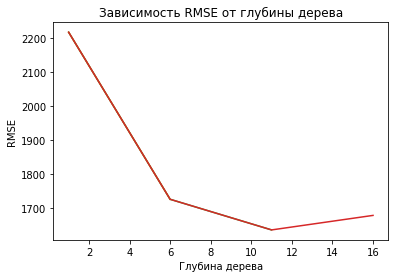

In [ ]:
%%time
best_result = 5000
depth = 0
depths = []
results = []

for depth in range(1, 21, 5):
    model_cb = CatBoostRegressor(iterations=30, learning_rate=1, max_depth=depth, random_state=12345, verbose=5)
    model_cb.fit(features_train, target_train, cat_features=cat_features)
    predictions_valid = model_cb.predict(features_valid)
    result = mean_squared_error(target_valid, predictions_valid) ** .5
    depths.append(depth)
    results.append(result)

    plt.plot(depths, results)
    plt.title("Зависимость RMSE от глубины дерева")
    plt.xlabel("Глубина дерева")
    plt.ylabel("RMSE")
    plt.grid()
    plt.show
            
    if result < best_result:
        best_depth = depth
        best_result = result

display(best_result, best_depth)

### Модель дерева решений

Создадим цикл, в котором переберём четыре модели деревьев с разной глубиной, обучим каждую на обучающей выборке, проверим результат обучения на валидационной выборке и выберем из них дерево с минимальной *RMSE*.

1878.6296288229814

13

CPU times: user 3.29 s, sys: 16.6 ms, total: 3.3 s
Wall time: 3.31 s


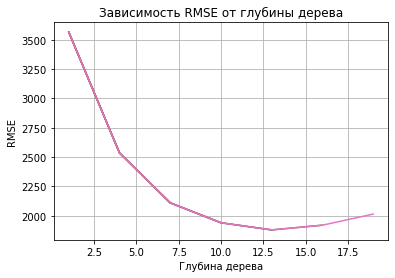

In [ ]:
%%time
best_result = 5000
depth = 0
depths = []
results = []

for depth in range(1, 21, 3):
    model_dtr = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model_dtr.fit(features_train, target_train)
    predictions_valid = model_dtr.predict(features_valid)
    result = mean_squared_error(target_valid, predictions_valid) ** .5
    depths.append(depth)
    results.append(result)
        
    plt.plot(depths, results)
    plt.title("Зависимость RMSE от глубины дерева")
    plt.xlabel("Глубина дерева")
    plt.ylabel("RMSE")
    plt.grid()
    plt.show
            
    if result < best_result:
        best_depth = depth
        best_result = result

display(best_result, best_depth)

### Градиентный бустинг *LightGBM*

Установка параметров

In [ ]:
params = {"iterations": 20,
          "learning_rate": 1,
          "max_depth": None,
          "loss_function": "RMSE",
          "random_state": 12345,
          "bootstrap_type": 'gbdt',
          "min_data_in_leaf": 1
          }

lgbm_train_data = lightgbm.Dataset(features_train, label=target_train)

arguments = {'learning_rate': 1,
         'metric': 'rmse',
         'seed': 12345,
         'objective': 'regression',
         'verbosity': -1,
        }

max_depth = [1, 6, 11]

Поиск лучшей глубины

In [ ]:
%time
best_score = 5000
for depth in max_depth:
    arguments['max_depth'] = depth
    score = lightgbm.cv(arguments, lgbm_train_data, nfold=3, categorical_feature=cat_features)
    score = pd.DataFrame(score).iloc[-1]['rmse-mean']
    if score < best_score:
        best_score = score
        best_depth = depth

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.68 µs


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'NotRepaired', 'VehicleType']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


Обучение модели с полученными параметрами

In [ ]:
%%time
params['max_depth'] = best_depth
lgbm_model = lightgbm.train(arguments, lgbm_train_data, categorical_feature=cat_features, num_boost_round=400)
best_score, best_depth

CPU times: user 1min 40s, sys: 581 ms, total: 1min 41s
Wall time: 1min 42s


(1703.8985926107168, 6)

### Вывод

- Лучший результат *RMSE* показал *CatBoost* с глубиной 11 - 1636, за время 54.6s
- Лучший результат *RMSE* показало дерево с глубиной 13 - 1879, за время 3s
- Лучший результат *RMSE* показал *LightGBM* с глубиной 6 - 1704, за время 1min 49s

<br>По величине *RMSE* все модели удовлетворяют требуемому условию (*RMSE < 2500*)  
<br>По скорости обучения Дерево Решений значительно превосходит другие модели

## Анализ моделей

### Обучение модели *DecisionTreeRegressor* и получение предсказаний

In [ ]:
%time
model_dtr = DecisionTreeRegressor(random_state=12345, max_depth=13)
model_dtr.fit(features_train, target_train)
predictions_valid_dtr = model_dtr.predict(features_valid)
display(mean_squared_error(target_valid, predictions_valid_dtr) ** .5)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


1878.6296288229814

### Обучение модели *CatBoost* и получение предсказаний

In [ ]:
%time
model_cb = CatBoostRegressor(iterations=30, learning_rate=1, max_depth=11, random_state=12345, verbose=5)
model_cb.fit(features_train, target_train, cat_features=cat_features)
predictions_valid_cb = model_cb.predict(features_valid)
display(mean_squared_error(target_valid, predictions_valid_cb) ** .5)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
0:	learn: 2314.0646773	total: 144ms	remaining: 4.17s
5:	learn: 1781.0114821	total: 811ms	remaining: 3.24s
10:	learn: 1685.3031966	total: 1.43s	remaining: 2.46s
15:	learn: 1610.6700607	total: 2.04s	remaining: 1.78s
20:	learn: 1563.6385429	total: 2.66s	remaining: 1.14s
25:	learn: 1530.5404542	total: 3.28s	remaining: 505ms
29:	learn: 1513.1028589	total: 3.78s	remaining: 0us


1636.3559006849168

### Обучение модели *LightGBM* и получение предсказаний

In [ ]:
%time
params['max_depth'] = 6
lgbm_test_data = lightgbm.Dataset(features_valid, label=target_valid)
predictions_valid_lgbm = lgbm_model.predict(features_valid)
display(mean_squared_error(target_valid, predictions_valid_lgbm) ** .5)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


1697.4589365022177

### Вывод

При проведении получения предсказаний модели проявили себя следующим образом:
- *DecisionTreeRegressor* - *RMSE* 1879, *time* 9.3 µs
- *CatBoost* - *RMSE* 1636, *time* 8.82 µs
- *LightGBM* - *RMSE* 1697, *time* 5.48 µs

<br>По величине *RMSE* все модели удовлетворяют требуемому условию (*RMSE < 2500*)  
<br>По скорости получения предсказаний модели выдают примерно одинаковые результаты

## Проверка лучшей модели на тестовой выборке

Лучшей моделью выбрана модель *DecisionTreeRegressor*. Получение предсказаний на тестовой выборке

In [ ]:
model_dtr = DecisionTreeRegressor(random_state=12345, max_depth=13)
model_dtr.fit(features_80, target_80)
predictions_test_dtr = model_dtr.predict(features_test)
display(mean_squared_error(target_test, predictions_test_dtr) ** .5)

1849.7759999279917

**Вывод**
<br>Качество предсказаний, полученное на тестовой выборке удовлетворяет обозначенному условию

## Общий вывод

По результатам исследования можем сделать следующие выводы:
- в ходе предобработки и анализа полученных данных удалены ненужные признаки, категориальные признаки преобразованы в количественные, обработаны пропуски в признаках, удалены аномальные значения признаков
- подготовлены выборки для обучения моделей при помощи *train_test_split*
- обучены три модели с подбором оптимальных параметров для решения поставленной задачи:
    - *DecisionTreeRegressor* - подобрана оптимальныя глубина 13 за 3s
    - *CatBoost* - подобрана оптимальная глубина 11 за 54.6s
    - *LightGBM* - подобрана оптимальная глубина 6 за 1min 49s
- при проведении получения предсказаний модели проявили себя следующим образом:
    - *DecisionTreeRegressor* - *RMSE* 1879, *time* 9.3 µs
    - *CatBoost* - *RMSE* 1636, *time* 8.82 µs
    - *LightGBM* - *RMSE* 1697, *time* 5.48 µs
- **общее заключение: для решения поставленной задачи наиболее подходящей моделью является *DecisionTreeRegressor***:
    - схожие результаты с остальными моделями по двум из трёх требуемых условий (скорость предсказания и значение *RMSE < 2500*)
    - значительно более низкий показатель по третьей метрике заказчика (время обучения)